In [3]:
#Import the standard pylab libraries, matplotlib.pyplot as plt , numpy as np
%pylab inline

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/Users/navjot/miniconda3/envs/devito/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Breast Cancer example revisited
Let's revisit an example we saw on the first day - the breast cancer dataset. 

A quick recap of what we did then:
- Load the data
- PCA transform
- Train LogisticRegression classifier
- Report performance

Today we would like to:
- Redo the exercise here, but this time split the data into test/train and report your accuracy on the test set. 

- The [Logistic Regression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) accepts a _C_ parameter, that is the inverse regularization strength. Find the value of C that gives the best accuracy. 

- Use a [convenience tool](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to automatically conduct such analyses and find the best value for C. Does PCA improve the results or worsen them? Does scaling improve or worsen them?



 Accuracy obtained with Logistic Regression: 95.6 percent 



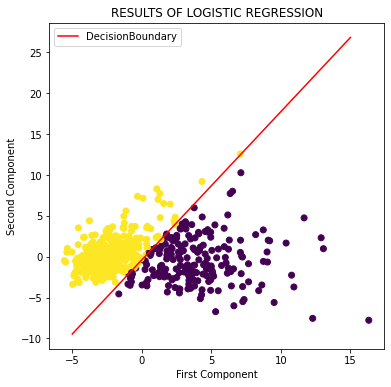

In [8]:
from sklearn.datasets import load_breast_cancer
from   sklearn.linear_model    import LogisticRegression
from sklearn.decomposition import PCA
from   sklearn.metrics         import accuracy_score
from sklearn.preprocessing import StandardScaler


X, y = load_breast_cancer(return_X_y=True)
scaler = StandardScaler()
Xscaled  = scaler.fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(Xscaled)



clf     = LogisticRegression(solver='lbfgs')
clf.fit(X_pca, y)
y_logis = clf.predict(X_pca)
coef    = clf.coef_
bias    = clf.intercept_

xlin     = pylab.linspace(-5, 15, 3000)
ylin     = -(bias[0]+coef[0,0]*xlin)/coef[0,1]

print('\n'*2,"Accuracy obtained with Logistic Regression: %2.1f percent" % (accuracy_score(y, y_logis)*100),'\n'*1)
plt.figure  (figsize=(6,6))
plt.scatter (X_pca[:, 0], X_pca[:, 1], c=y_logis)
plt.plot    (xlin, ylin, 'r-', label='DecisionBoundary')
plt.xlabel  ('First Component')
plt.ylabel  ('Second Component')
plt.title   ('RESULTS OF LOGISTIC REGRESSION')
plt.legend  ()
plt.show    ()

What is wrong with the above accuracy score?

We are reporting accuracy on the same data that we used to train the classifier! The classifier has seen the labels for all these examples (and still gets ~4% wrong)!

Ideally, we should split this data into a train/test/validation split and only report the performance on the test dataset. We will use the StratifiedShuffleSplit to create a 80/20 train/test split.

In [11]:
from   sklearn.preprocessing   import StandardScaler
from   sklearn.model_selection import StratifiedShuffleSplit


indices = StratifiedShuffleSplit(test_size=0.2, random_state=0).split(X, y)
train_index, valid_index = list(indices)[0]
X_train, X_valid = X[train_index], X[valid_index]
y_train, y_valid = y[train_index], y[valid_index]
"""
For the given split evaluate the impact of the regularization strength factor C
"""
Cs = [0.001, 0.01, 0.1, 1., 10]
train_valid_accs = []

scaler      = StandardScaler()
X_train_pre = scaler.fit_transform(X_train)
X_valid_pre = scaler.transform(X_valid)

for C in Cs:
    """
    In LogisticRegression, the larger C the less we regularize
    """
    clf      = LogisticRegression(C=C, solver="lbfgs")
    clf.fit(X_train_pre, y_train)
    y_train_ = clf.predict(X_train_pre)
    y_valid_ = clf.predict(X_valid_pre)
    
    train_acc, valid_acc = accuracy_score(y_train, y_train_)*100, accuracy_score(y_valid, y_valid_)*100
    train_valid_accs.append([train_acc, valid_acc])
    
    print("Regularization Strength: ", C, 
          " Train Accuracy: %2.1f percent" % train_acc,  
          " Validation Accuracy: %2.1f percent" % valid_acc)
train_valid_accs = np.array(train_valid_accs)


Regularization Strength:  0.001  Train Accuracy: 89.9 percent  Validation Accuracy: 87.7 percent
Regularization Strength:  0.01  Train Accuracy: 95.2 percent  Validation Accuracy: 95.6 percent
Regularization Strength:  0.1  Train Accuracy: 98.2 percent  Validation Accuracy: 96.5 percent
Regularization Strength:  1.0  Train Accuracy: 98.9 percent  Validation Accuracy: 98.2 percent
Regularization Strength:  10  Train Accuracy: 99.1 percent  Validation Accuracy: 97.4 percent


### Plot regularization strength vs. Test and Train Accuracy on a log scale. Which factor of C do you choose?

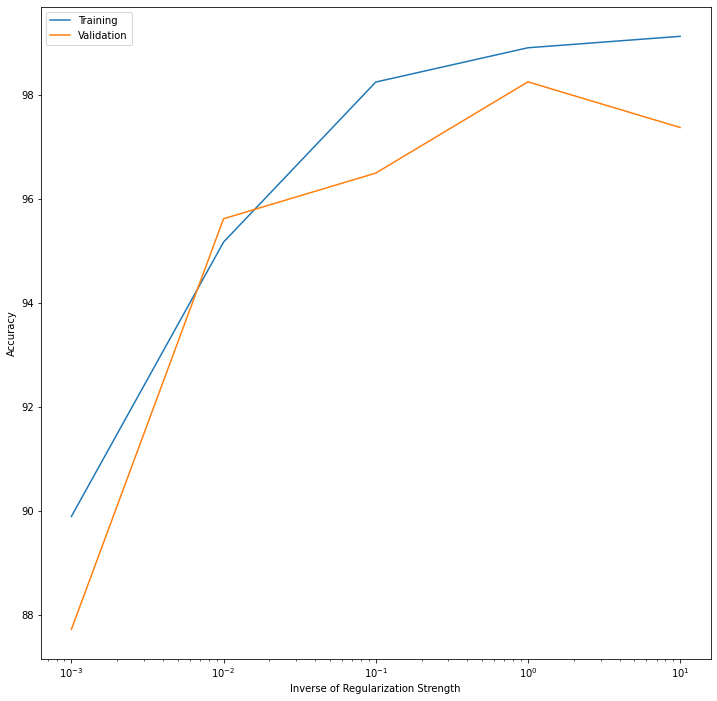

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.plot(Cs, train_valid_accs[:, 0], label='Training')
ax.plot(Cs, train_valid_accs[:, 1], label='Validation')
ax.set_xscale("log")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Inverse of Regularization Strength")
plt.legend()
plt.show()

## GridSearch

The above hyperparameter search is so common that we often have utilities to automate this for us. 

In [22]:
from sklearn.model_selection import GridSearchCV

gspca = GridSearchCV(LogisticRegression(solver='lbfgs'), {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1., 10, 100, 1000]}, cv=5)

gspca.fit(X_pca, y)

gspca.cv_results_

{'mean_fit_time': array([0.0030314 , 0.0028646 , 0.00221772, 0.00215344, 0.00214372,
        0.00251417, 0.00244217, 0.00255766, 0.00275779]),
 'std_fit_time': array([3.57006379e-04, 4.35970834e-04, 2.20449992e-04, 1.95987114e-04,
        9.63368733e-05, 3.95070432e-04, 3.91003865e-04, 4.14697812e-04,
        4.82402864e-04]),
 'mean_score_time': array([0.00035181, 0.0002583 , 0.00022011, 0.00022092, 0.00022306,
        0.00021582, 0.000213  , 0.00028658, 0.00022764]),
 'std_score_time': array([1.51712439e-04, 2.08953721e-05, 1.00785374e-05, 9.99494362e-06,
        3.28929862e-05, 1.28316162e-05, 1.31278388e-05, 8.36542812e-05,
        1.58331479e-05]),
 'param_C': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1

In [23]:
gspca.best_params_

{'C': 10}

In [24]:
gspca.best_score_

0.9543549138332557

#### Without PCA

In [26]:
from sklearn.model_selection import GridSearchCV

gsnpca = GridSearchCV(LogisticRegression(solver='lbfgs'), {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1., 10, 100, 1000]}, cv=5)

gsnpca.fit(Xscaled, y)

gsnpca.cv_results_

/Users/navjot/miniconda3/envs/devito/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/navjot/miniconda3/envs/devito/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

{'mean_fit_time': array([0.00447364, 0.00324178, 0.00308881, 0.00334015, 0.00439897,
        0.0078444 , 0.01460214, 0.01701245, 0.01694822]),
 'std_fit_time': array([0.0004639 , 0.00034553, 0.0002902 , 0.00053789, 0.00125392,
        0.00061882, 0.00166743, 0.00072583, 0.00072622]),
 'mean_score_time': array([0.00038857, 0.00029769, 0.00026135, 0.00027919, 0.00025301,
        0.00026731, 0.00026698, 0.00044594, 0.00041227]),
 'std_score_time': array([9.67775521e-05, 4.60503742e-05, 2.34249864e-05, 4.51997863e-05,
        1.30547181e-05, 5.38087017e-06, 1.41085793e-05, 9.40778807e-05,
        3.43893160e-05]),
 'param_C': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10},
  {'C': 100},
  {'C': 1000

In [27]:
gsnpca.best_params_

{'C': 1.0}

In [29]:
gsnpca.best_score_

0.9806862288464524

Although the value of C is the same as the one with the manual exercise, the accuracy is slightly different. This is probably because of the randomness in data selection (the automated version does 5-fold cross validation while in the manual version we did a single 0.2 train-test split). 

Hence, the best accuracies we have seen are 98.06% without PCA and 95.44% with PCA. It's not surprising that the model with all features performs better than the model with only two PCA components. In fact the surprise is that PCA performs so well in only two components!

### Bonus Reading Material

A major problem in using Deep Neural Networks is the difficulty of understanding _what_ a Neural Network is doing. Read the blog post 
[here](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/) by 
[Chris Olah](https://ai.google/research/people/ChristopherOlah) on the topology of neural networks.
